In [1]:
import random
import itertools

import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, IBMQ
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import qiskit.tools.jupyter
from qiskit_textbook.tools import array_to_latex

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

C:\Users\antho\Projects\quantum_computing\qosf_mentorship_applicant_task\venv\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Task 2
Implement a circuit that returns |01> and |10> with equal probability (50% for each).
Requirements :
* The circuit should consist only of CNOTs, RXs and RYs. 
* Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
* You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
* Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

* Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

Bonus question:
* How to make sure you produce state |01> + |10> and not |01> - |10> ?

(Actually for more careful readers, the “correct” version of this question is posted below:
How to make sure you produce state  |01⟩  +  |10⟩  and not any other combination of |01> + e(i*phi)|10⟩ (for example |01⟩  -  |10⟩)?)

In [2]:
N_QUBITS = 2
N_ITER = 2
BACKEND = "qasm_simulator"
cost_list = []


def get_cost_from_ansatz(theta, params):
    """Run simulation and calculate cost from measured outputs

    Args:
        theta (list): Parameters being optimized for ansatz. Ranges [0, 2pi]
        params (tuple): Tuple of static parameters to pass into the minimizer function of scipy.optimize.minimize

    Returns:
        float: Cost/Loss
    """    
    
    n_qubits, n_shots, backend = params
    qc = get_ansatz_circuit(theta)

    backend = Aer.get_backend(backend)
    result_sim = execute(
        qc,
        backend,
        basis_gates=noise_model.basis_gates,
        noise_model=noise_model,
        shots=n_shots,
    ).result()
    counts = result_sim.get_counts(qc)

    p = {}
    binary_states = [
        "".join(map(str, list(i))) for i in itertools.product([0, 1], repeat=n_qubits)
    ]
    for i, val in enumerate(binary_states):
        if val in counts.keys():
            p[i] = counts[val] / n_shots
        else:
            p[i] = 0

    p_vals = list(p.values())
    total_count = np.sum(p_vals)
    cost = (p_vals[1] - total_count / 2) ** 2 + (p_vals[2] - total_count / 2) ** 2
    global cost_list
    cost_list.append(cost)
    return cost


def get_ansatz_circuit(theta, measure=True, n_qubits=N_QUBITS):
    """
    Generates the ansatz circuit to be optimized

    Args:
        theta (float): Parameter being optimized. Ranges [0, 2pi]
        measure (bool, optional): Whether to measure the Quantum Circuit upon creation or not
        n_qubits (int, optional): Number of qubits in circuit

    """
    
    # Create the quantum circuit
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(n_qubits)
    qc = QuantumCircuit(q, c)

    # first create equal super position state
    qc.cx(1, 0)
    qc.ry(theta[0], 1)
    qc.ry(theta[1], 0)
    qc.cx(1, 0)

    if measure:
        qc.measure(q, c)
    return qc


def get_noise_model(param_q0, param_q1):
    """Noise Model for the quantum circuit.

    Args:
        param_q0 (float): damping parameter for qubit 0
        param_q1 (float): damping parameter for qubit 1
    Returns:
        NoiseModel: NoiseModel for the two qubit system with the model applied on the cx gate.
    """

    # Construct the error
    qerror_q0 = amplitude_damping_error(param_q0)
    qerror_q1 = amplitude_damping_error(param_q1)
    cnot_error = qerror_q1.tensor(qerror_q0)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(cnot_error, "cx")

    return noise_model


def run(
    n_qubits=N_QUBITS,
    n_shots=10000,
    backend=BACKEND,
    damp_param_q0=0,
    damp_param_q1=0,
):
    """Run the QAOA experiment.

    Args:
        n_qubits (int, optional): Number of qubits in circuit. Defaults to N_QUBITS.
        n_shots (int, optional): Number of shots/measurements. Defaults to 10000.
        backend (str, optional): Aer backend to simulate with. Defaults to BACKEND.
        damp_param_q0 (int, optional): NoiseModel damping parameter for qubit 0. Defaults to 0.
        damp_param_q1 (int, optional): NoiseModel damping parameter for qubit 1. Defaults to 0.

    Returns:
        bool: Check if acquired statevector from optimization is of the desired form |01> + |10> and not |01> - |10>
    """    
    theta_i = np.random.uniform(0, 2 * np.pi, size=n_qubits)
    global noise_model
    noise_model = get_noise_model(damp_param_q0, damp_param_q1)
    params = n_qubits, n_shots, backend

    # find optimal theta
    # res = minimize(circuit_ansatz, theta_i, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
    opt_res = minimize(get_cost_from_ansatz, theta_i, args=(params,), method="powell")
    theta_opt = opt_res.x

    qc = get_ansatz_circuit(theta_opt)
    backend = Aer.get_backend(backend)
    measurement_result = {}
    for n_shots_plt in [1, 10, 100, 1000, 10000, 50000]:
        sim_result = execute(
            qc,
            backend,
            basis_gates=noise_model.basis_gates,
            noise_model=noise_model,
            shots=n_shots_plt,
        ).result()
        measurement_result[n_shots_plt] = sim_result.get_counts(qc)

    qc = get_ansatz_circuit(theta_opt, measure=False)
    backend = Aer.get_backend("statevector_simulator")
    final_state = (
        execute(
            qc,
            backend,
            basis_gates=noise_model.basis_gates,
            noise_model=noise_model,
            shots=n_shots_plt,
        )
        .result()
        .get_statevector()
    )
    if final_state[1] > 0 and final_state[2] > 0:
        display(
            plot_histogram(
                measurement_result.values(), legend=list(measurement_result.keys())
            )
        )
        display(qc.draw(output="mpl"))
        array_to_latex(final_state, pretext="\\text{Statevector = }")

        plot_bloch_multivector(final_state)
        return False
    return True


## no noise

N shots for current optimization run: 1


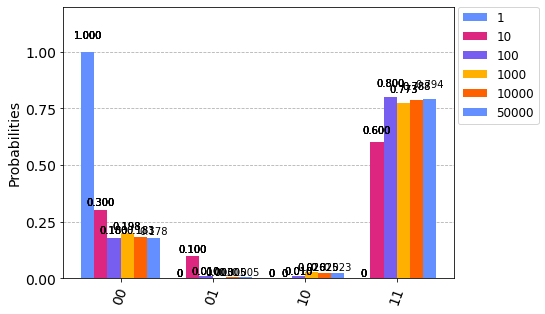

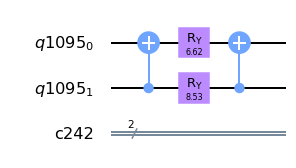

<IPython.core.display.Math object>

N shots for current optimization run: 10


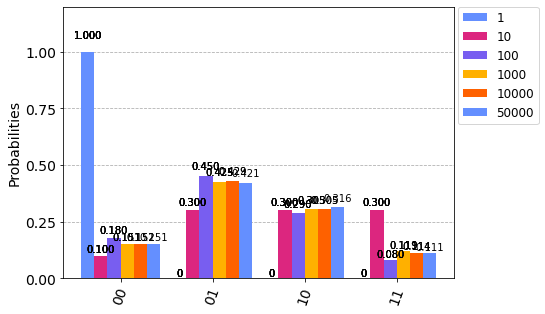

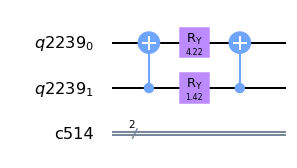

<IPython.core.display.Math object>

N shots for current optimization run: 100


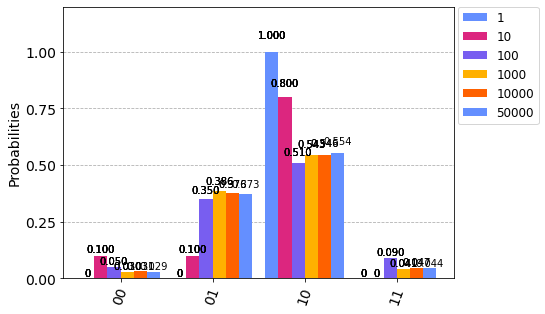

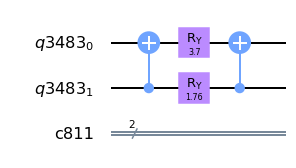

<IPython.core.display.Math object>

N shots for current optimization run: 1000


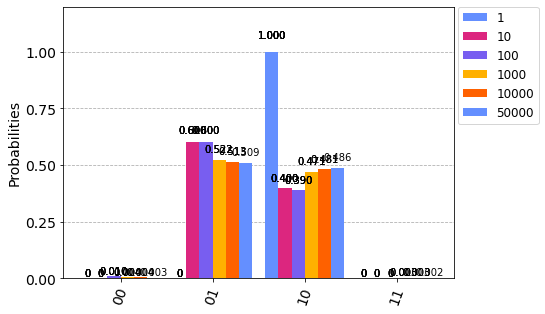

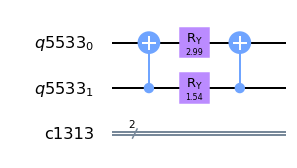

<IPython.core.display.Math object>

N shots for current optimization run: 10000


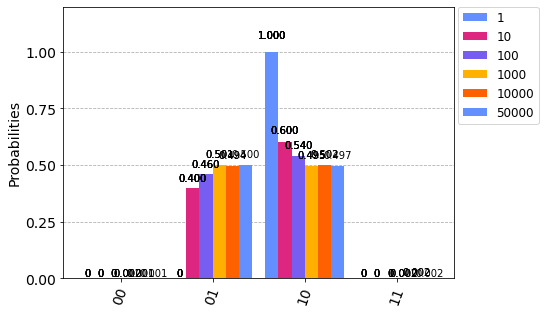

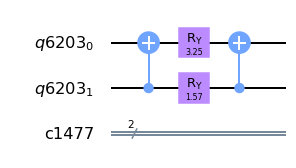

<IPython.core.display.Math object>

In [3]:
for n_shots in [1, 10, 100, 1000, 10000]:
    print(f"N shots for current optimization run: {n_shots}")
    not_correct_final_state = True
    while not_correct_final_state:
        not_correct_final_state = run(n_shots=n_shots)

## noise: q0=0.025 and q1=0.1

N shots for current optimization run: 1


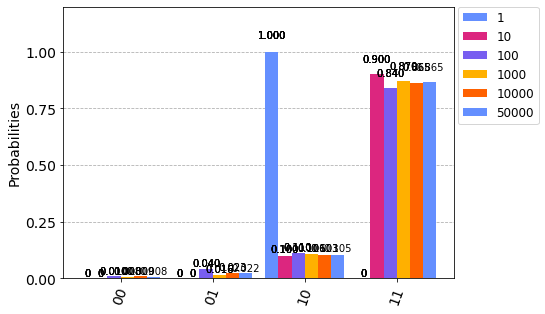

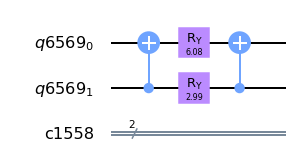

<IPython.core.display.Math object>

N shots for current optimization run: 10


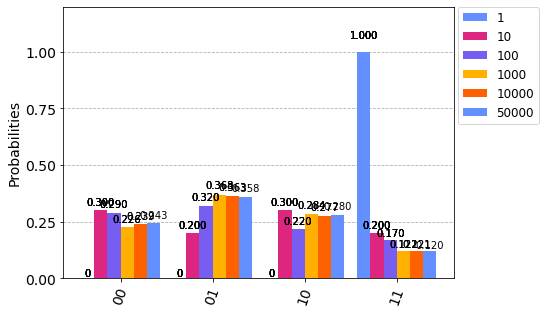

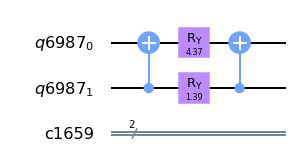

<IPython.core.display.Math object>

N shots for current optimization run: 100


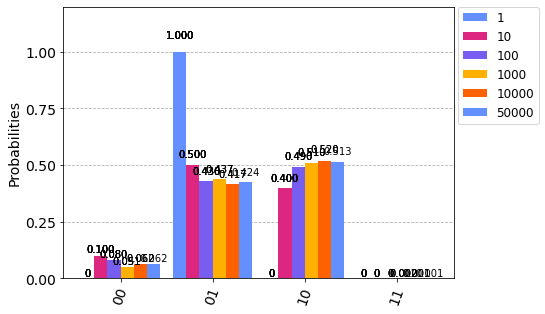

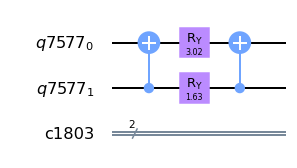

<IPython.core.display.Math object>

N shots for current optimization run: 1000


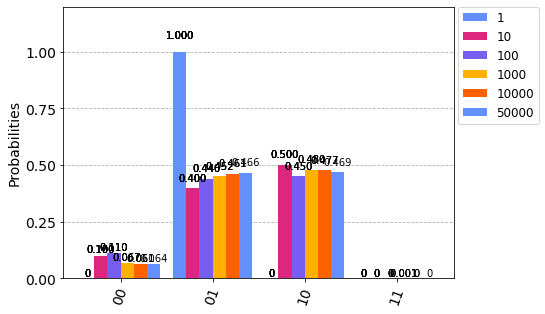

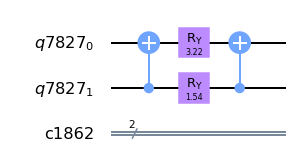

<IPython.core.display.Math object>

N shots for current optimization run: 10000


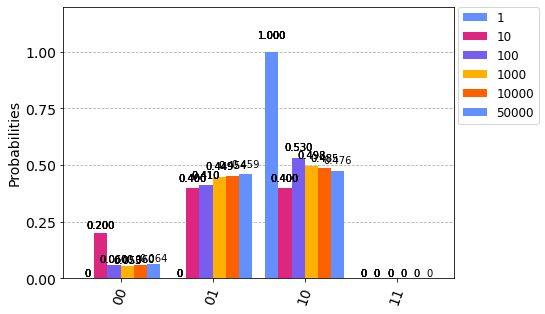

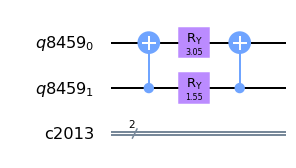

<IPython.core.display.Math object>

In [4]:
for n_shots in [1, 10, 100, 1000, 10000]:
    print(f"N shots for current optimization run: {n_shots}")
    not_correct_final_state = True
    while not_correct_final_state:
        not_correct_final_state = run(n_shots=n_shots, damp_param_q0=0.025, damp_param_q1=0.1)

## by utilizing the above state vector representation of our output state the solution is as expected. Namely, $$\psi \approx \frac{|01> + |10>}{\sqrt2}$$